# 5. Ensembling Model

In [ ]:
from sqlalchemy import create_engine
from pandasql import sqldf

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scipy.stats as st
from mlxtend.plotting import plot_decision_regions
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

from collections import OrderedDict, Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, f1_score 
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
# make prettier plots
%config InlineBackend.figure_format = 'svg'


import itertools
import pickle

from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor, StackingClassifier)

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

In [10]:
def plot_roc(true, probas):
    auc = roc_auc_score(true, probas)
    plt.plot(fpr, tpr, marker='o')
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 4)}");

In [11]:
cmp_all= pd.read_csv('cmp1.csv')

# Handling Imbalanced Classes: Stratify=target variable

In [12]:
X_tr_v, X_te, y_tr_v, y_te = train_test_split(cmp_all.drop(['id','success'],axis=1), cmp_all['success'], test_size=0.2, random_state=41, stratify=cmp_all['success'])
X_tr, X_v, y_tr, y_v= train_test_split(X_tr_v, y_tr_v, test_size=0.3, random_state=41, stratify=y_tr_v)

In [13]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

In [6]:
knn_model=KNeighborsClassifier(n_neighbors=10)
lr_model = LogisticRegression(C=0.95)
nb_model = GaussianNB()
#svc_model= SVC(probability=True)
XGB_model= XGBClassifier()
dt_model = DecisionTreeClassifier(max_depth=3)
rf_model = RandomForestClassifier(n_estimators=500)
et_model = ExtraTreesClassifier()
ada_model = AdaBoostClassifier()



print('knn_model:',quick_test_afew_times(knn_model, X_tr_v, y_tr_v))
print('LogisticRegression:',quick_test_afew_times(lr_model, X_tr_v, y_tr_v))
print('GaussianNB:',quick_test_afew_times(nb_model, X_tr_v, y_tr_v))
#print('SVC:',quick_test_afew_times(svc_model, X_tr_v, y_tr_v))
print('XGB:',quick_test_afew_times(XGB_model, X_tr_v, y_tr_v))
print('DecisionTree:',quick_test_afew_times(dt_model, X_tr_v, y_tr_v))
print('RandomForest:',quick_test_afew_times(rf_model, X_tr_v, y_tr_v))
print('ExtraTrees:',quick_test_afew_times(et_model, X_tr_v, y_tr_v))
print('AdaBoost:',quick_test_afew_times(ada_model, X_tr_v, y_tr_v))



knn_model: 0.8917387927208166
LogisticRegression: 0.8610852197070573
GaussianNB: 0.856696626719929


/Users/yuwenhuang/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:28:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:28:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:29:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:29:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

In [59]:
knn_model=KNeighborsClassifier(n_neighbors=5)
lr_model = LogisticRegression(C=0.95)
nb_model = GaussianNB()
svc_model= SVC(probability=True)
XGB_model= XGBClassifier()
dt_model = DecisionTreeClassifier(max_depth=3)
rf_model = RandomForestClassifier(n_estimators=100)
et_model = ExtraTreesClassifier()
ada_model = AdaBoostClassifier()

In [60]:
model_names = ["knn_model","lr_model", "nb_model", "svc_model"
               ,"XGB_model","dt_model","rf_model","et_model"]
#, "ada_model"]

In [61]:
model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

## Max Voting

In [ ]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', # <-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_tr, y_tr)

In [ ]:
y_pred = voting_classifer.predict(X_v)
print("accuracy score: ",accuracy_score(y_v, y_pred))
print("training score: {}".format(voting_classifer.score(X_tr, y_tr)))
print("testing score: {}".format(voting_classifer.score(X_v, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, voting_classifer.predict(X_v)))
print(classification_report(y_v, y_pred))

#predict_proba is not available when voting='hard'

#with adaBoost Classifer()

#accuracy score:  0.9077896138482024
#training score: 0.9234591972607952
#testing score: 0.9077896138482024
#confusion_matrix: 
# [[15455    42]
# [ 1620   907]]
#              precision    recall  f1-score   support
#
#           0       0.91      1.00      0.95     15497
#           1       0.96      0.36      0.52      2527
#
#    accuracy                           0.91     18024
#   macro avg       0.93      0.68      0.74     18024
#weighted avg       0.91      0.91      0.89     18024
#


## Weighted Voting

In [20]:
# create voting classifier
weights = [1,1,1,1,1.5,1.5,1,1]
voting_weight= VotingClassifier(estimators=model_list,
                                    voting='soft', # <-- sklearn calls this hard voting
                                    weights=weights,
                                    n_jobs=-1)
voting_weight.fit(X_tr, y_tr)

VotingClassifier(estimators=[('knn_model', KNeighborsClassifier()),
                             ('lr_model', LogisticRegression(C=0.95)),
                             ('nb_model', GaussianNB()),
                             ('svc_model', SVC(probability=True)),
                             ('XGB_model',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_c...
                                            random_state=None, reg_alpha=None,
                                            reg_lambda=None,
                                            scale_pos_weight=None,
                                            subsample=No

accuracy score:  0.9160563692853972
training score: 0.9259796461860377
testing score: 0.9160563692853972
confusion_matrix: 
 [[15456    41]
 [ 1472  1055]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     15497
           1       0.96      0.42      0.58      2527

    accuracy                           0.92     18024
   macro avg       0.94      0.71      0.77     18024
weighted avg       0.92      0.92      0.90     18024



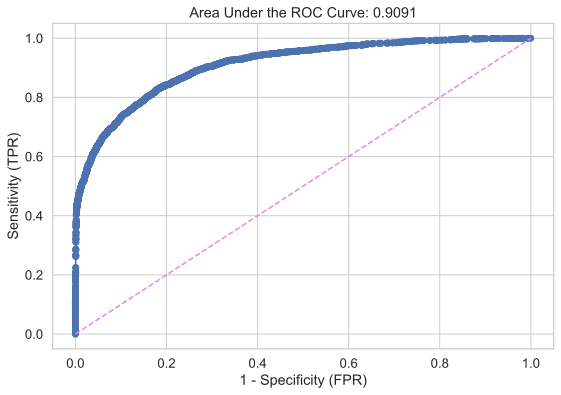

In [22]:
y_pred = voting_weight.predict(X_v)
print("accuracy score: ",accuracy_score(y_v, y_pred))
print("training score: {}".format(voting_weight.score(X_tr, y_tr)))
print("testing score: {}".format(voting_weight.score(X_v, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, voting_weight.predict(X_v)))
print(classification_report(y_v, y_pred))

proba=voting_weight.predict_proba(X_v)[:,1]
fpr, tpr, thresholds = roc_curve(y_v, proba)
plot_roc(y_v, proba)


#with adaBoost Classifer()
#accuracy score:  0.9160563692853972
#training score: 0.9259796461860377
#testing score: 0.9160563692853972
#confusion_matrix: 
# [[15456    41]
# [ 1472  1055]]
#              precision    recall  f1-score   support
#
#           0       0.91      1.00      0.95     15497
#           1       0.96      0.42      0.58      2527
#
#    accuracy                           0.92     18024
#   macro avg       0.94      0.71      0.77     18024
#weighted avg       0.92      0.92      0.90     18024

#ROC: 0.9091

## Visualizing the Weighted Voting System

In [62]:
knn_model.fit(X_tr,y_tr)
lr_model.fit(X_tr,y_tr)
nb_model.fit(X_tr,y_tr)
svc_model.fit(X_tr,y_tr)
XGB_model.fit(X_tr,y_tr)
dt_model.fit(X_tr,y_tr)
rf_model.fit(X_tr,y_tr)
et_model.fit(X_tr,y_tr)
ada_model.fit(X_tr,y_tr)

/Users/yuwenhuang/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:59:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


AdaBoostClassifier()

In [28]:
probas = [c.predict_proba(X_tr) for n,c in model_list]
probas += [voting_weight.predict_proba(X_tr)]
# get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]

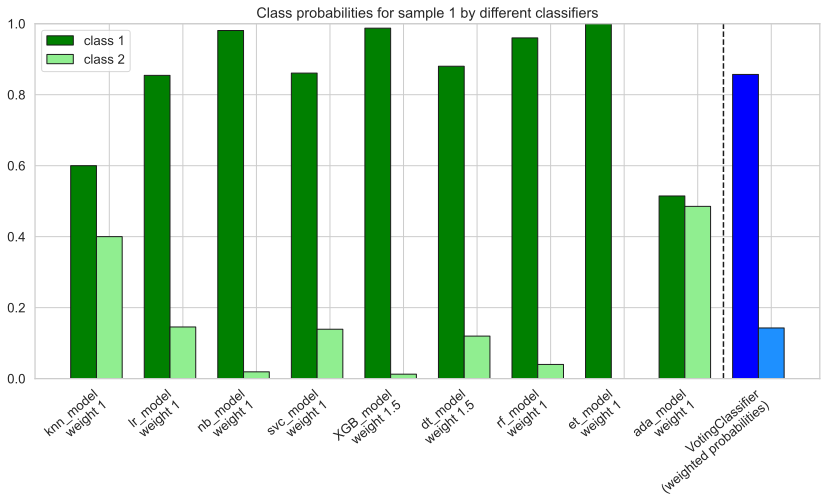

In [32]:
# plotting

N = 10  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig, ax = plt.subplots()

# bars for classifier 1-7
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), 
            width,
            color='green', 
            edgecolor='k')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), 
            width,
            color='lightgreen', 
            edgecolor='k')

# bars for VotingClassifier
p3 = ax.bar(ind, [0,0,0,0,0,0,0,0,0, class1_1[-1]], 
            width,
            color='blue', 
            edgecolor='k')
p4 = ax.bar(ind + width, [0,0,0,0,0,0,0,0,0, class2_1[-1]], 
            width,
            color='dodgerblue', 
            edgecolor='k')

# plot annotations
plt.axvline(N - 1.3, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
x_labels = [f"{n}\nweight {weights[i]}" for i, n in enumerate(model_names)]
ax.set_xticklabels(
    x_labels + ['VotingClassifier\n(weighted probabilities)'],
    rotation=40,
    ha='right')

plt.ylim([0, 1])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'], loc='upper left')
plt.tight_layout()
plt.gcf().set_size_inches(12, 8)
plt.show()

# XG Boost

In [14]:
gbm = xgb.XGBClassifier( 
        n_estimators=300000,
        max_depth=5, #5
        objective='binary:logistic', #new objective
        use_label_encoder=False,
        learning_rate=.04, #4
        subsample=.9,#9
        min_child_weight=6, #6
        colsample_bytree=.9)

eval_set=[(X_tr,y_tr),(X_v,y_v)]

fit_model = gbm.fit(
                X_tr, y_tr, 
                eval_set=eval_set,
                eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                early_stopping_rounds=50,
                verbose=False)

accuracy score:  0.9192188193519751
training score: 0.9187511888910025
testing score: 0.9192188193519751
confusion_matrix: 
 [[15404    93]
 [ 1363  1164]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     15497
           1       0.93      0.46      0.62      2527

    accuracy                           0.92     18024
   macro avg       0.92      0.73      0.79     18024
weighted avg       0.92      0.92      0.91     18024



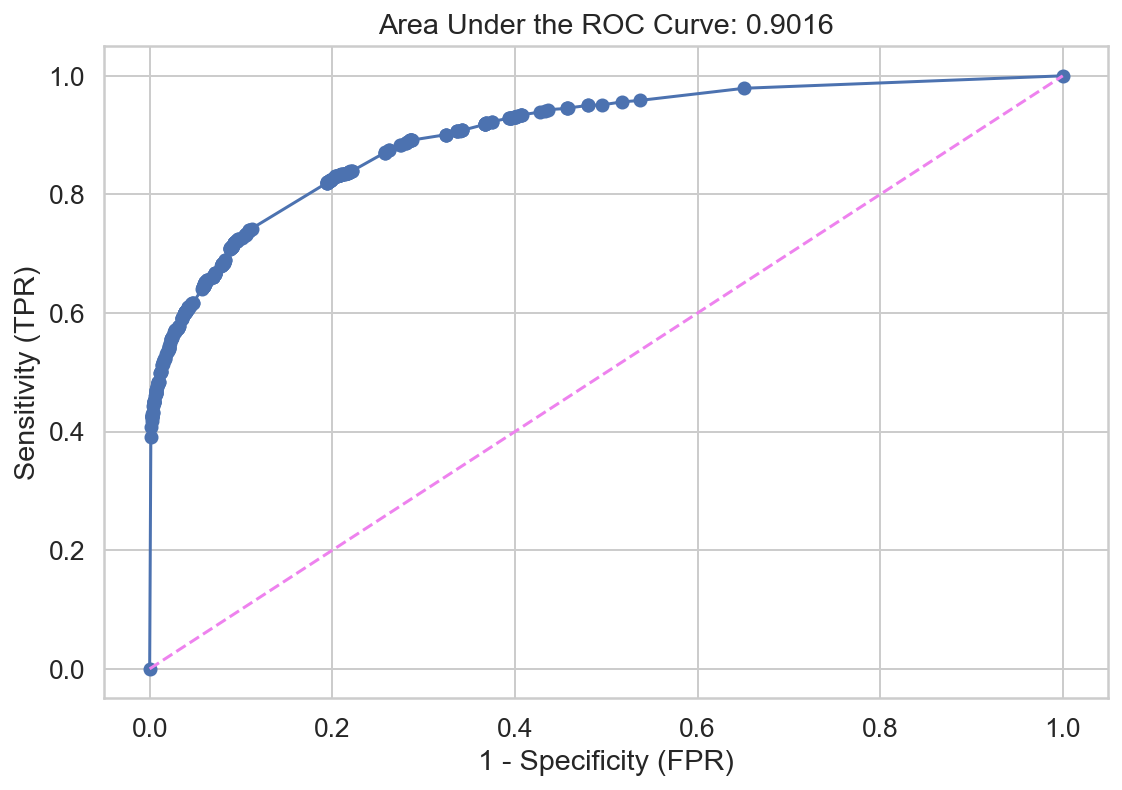

In [230]:
y_pred = gbm.predict(X_v)
print("accuracy score: ",accuracy_score(y_v, y_pred))
print("training score: {}".format(gbm.score(X_tr, y_tr)))
print("testing score: {}".format(gbm.score(X_v, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, gbm.predict(X_v)))
print(classification_report(y_v, y_pred))

proba=gbm.predict_proba(X_v)[:,1]
fpr, tpr, thresholds = roc_curve(y_v, proba)
plot_roc(y_v, proba)

### score for test data

accuracy score:  0.9228413554357233
testing score: 0.9228413554357233
confusion_matrix: 
 [[12833    82]
 [ 1077  1029]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     12915
           1       0.93      0.49      0.64      2106

    accuracy                           0.92     15021
   macro avg       0.92      0.74      0.80     15021
weighted avg       0.92      0.92      0.91     15021



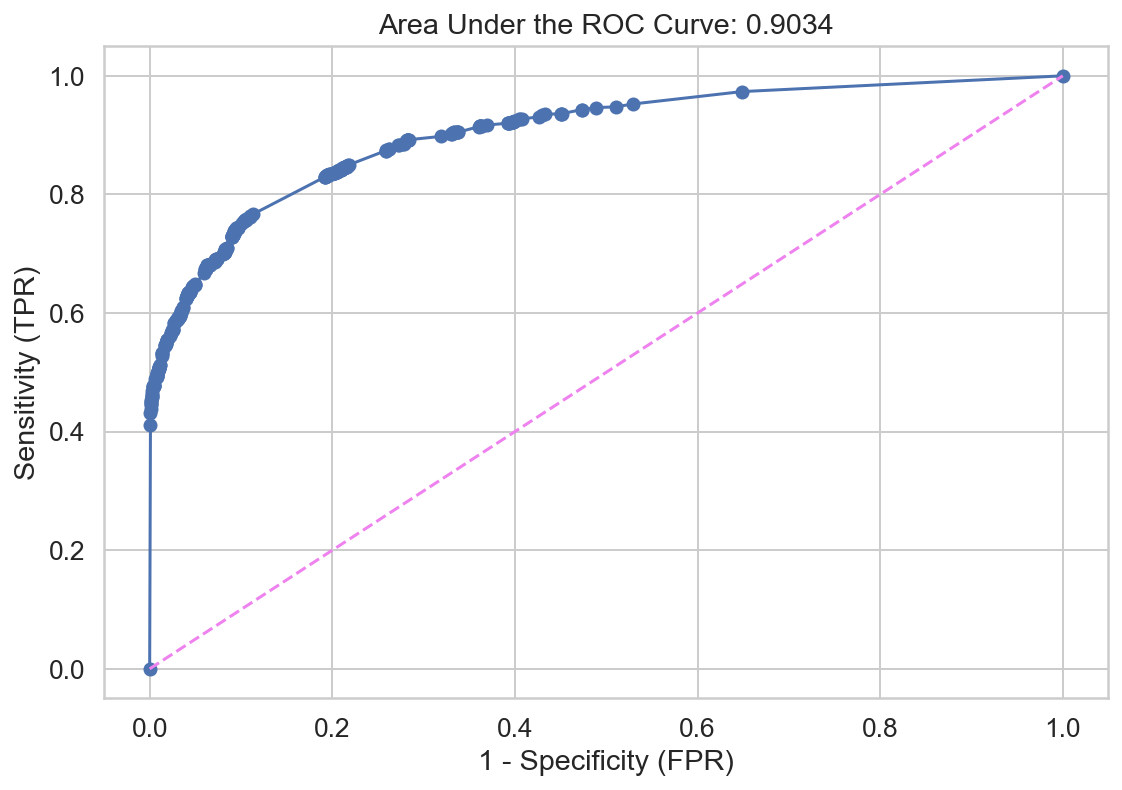

In [280]:
y_pred = gbm.predict(X_te)
print("accuracy score: ",accuracy_score(y_te, y_pred))
print("testing score: {}".format(gbm.score(X_te, y_te)))
print("confusion_matrix: \n", confusion_matrix(y_te, gbm.predict(X_te)))
print(classification_report(y_te, y_pred))

proba=gbm.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, proba)
plot_roc(y_te, proba)

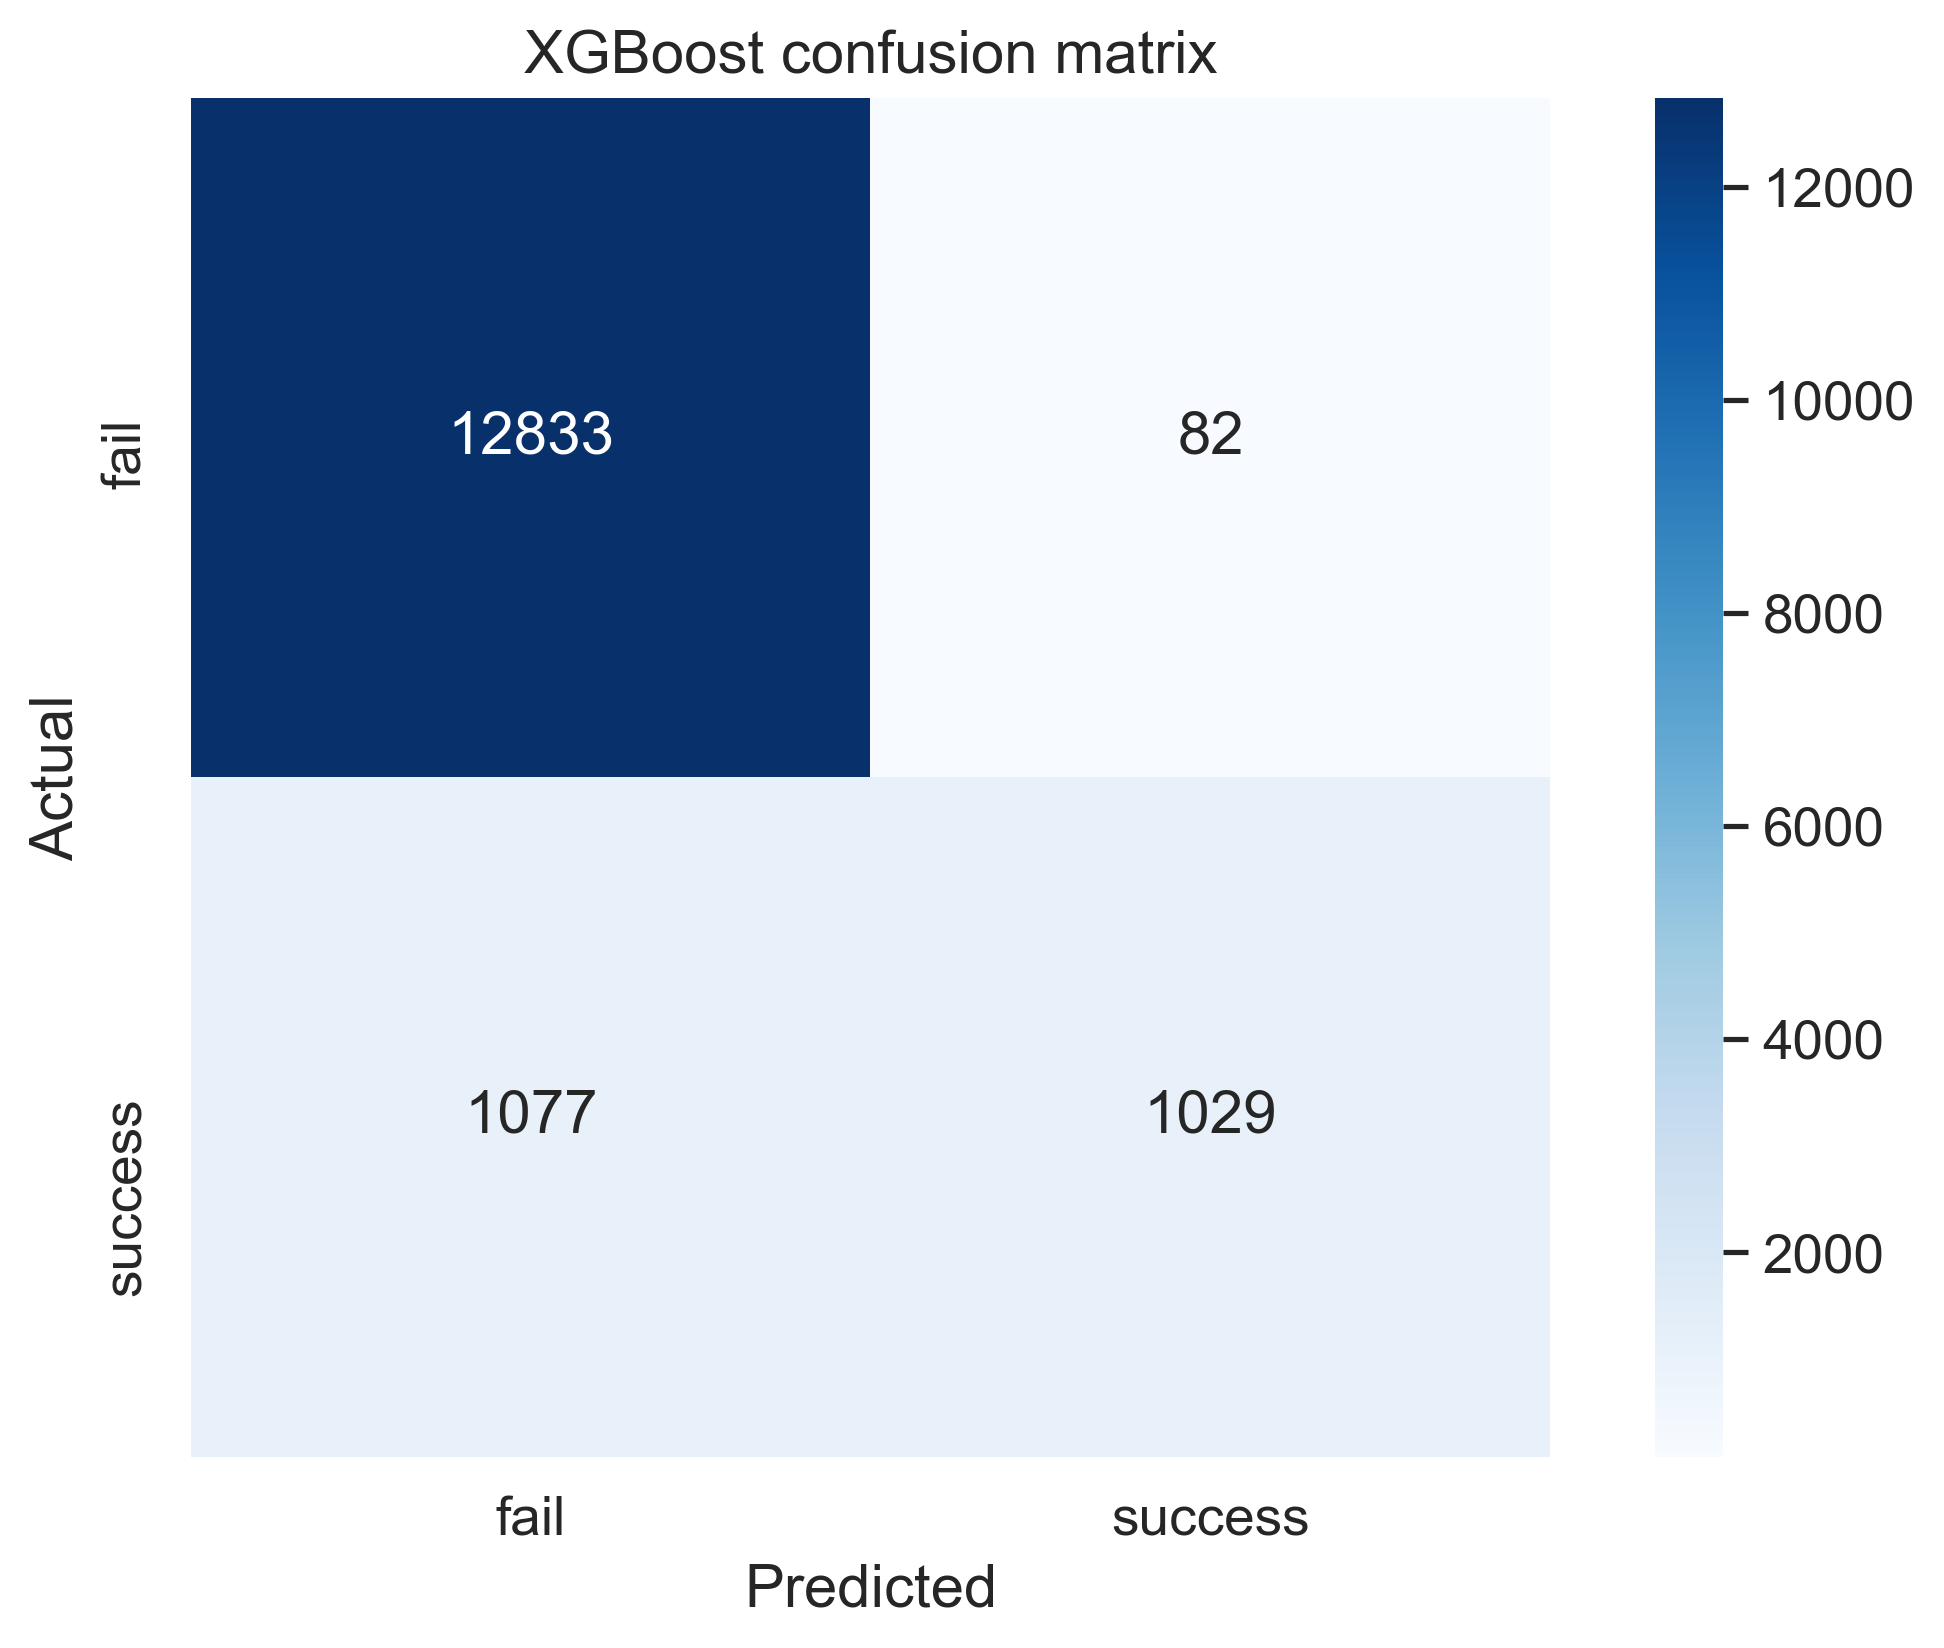

In [233]:
XGB_confusion = confusion_matrix(y_te, gbm.predict(X_te))
plt.figure(dpi=150)
sns.heatmap(XGB_confusion, cmap=plt.cm.Blues,
            annot=True, square=True, xticklabels=['fail','success'], yticklabels=['fail','success'],fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost confusion matrix');

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

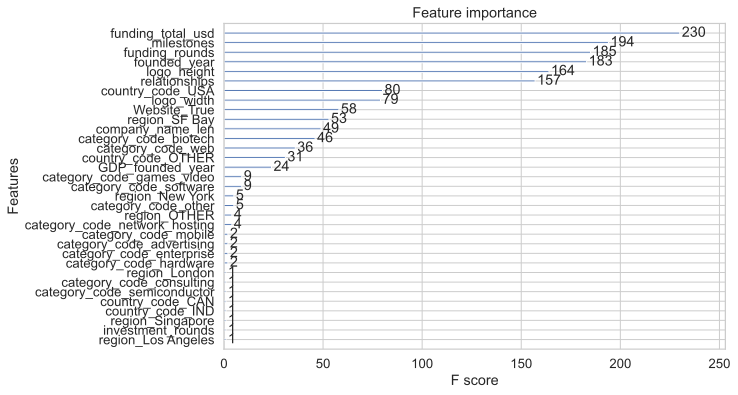

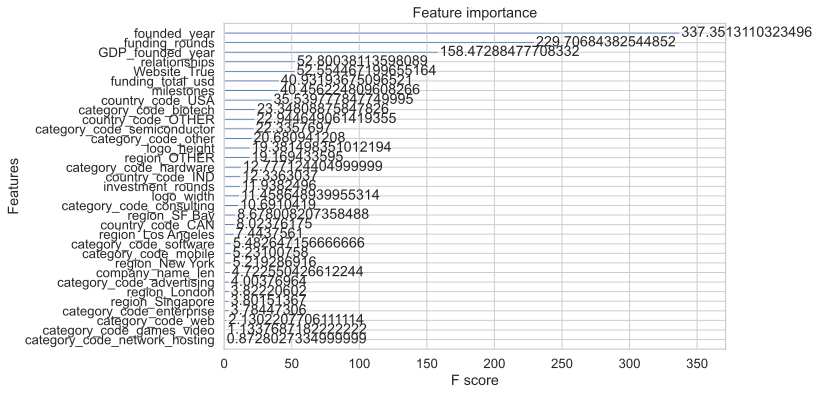

In [8]:
xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain')

In [52]:
col_sorted_by_importance=gbm.feature_importances_.argsort()[-10:]
feat_imp=pd.DataFrame({
    'cols':X_te.columns[col_sorted_by_importance[range(9,-1,-1)]],
    'imps':gbm.feature_importances_[col_sorted_by_importance[range(9,-1,-1)]]
})

import plotly_express as px
px.bar(feat_imp, x='cols', y='imps')


<BarContainer object of 20 artists>

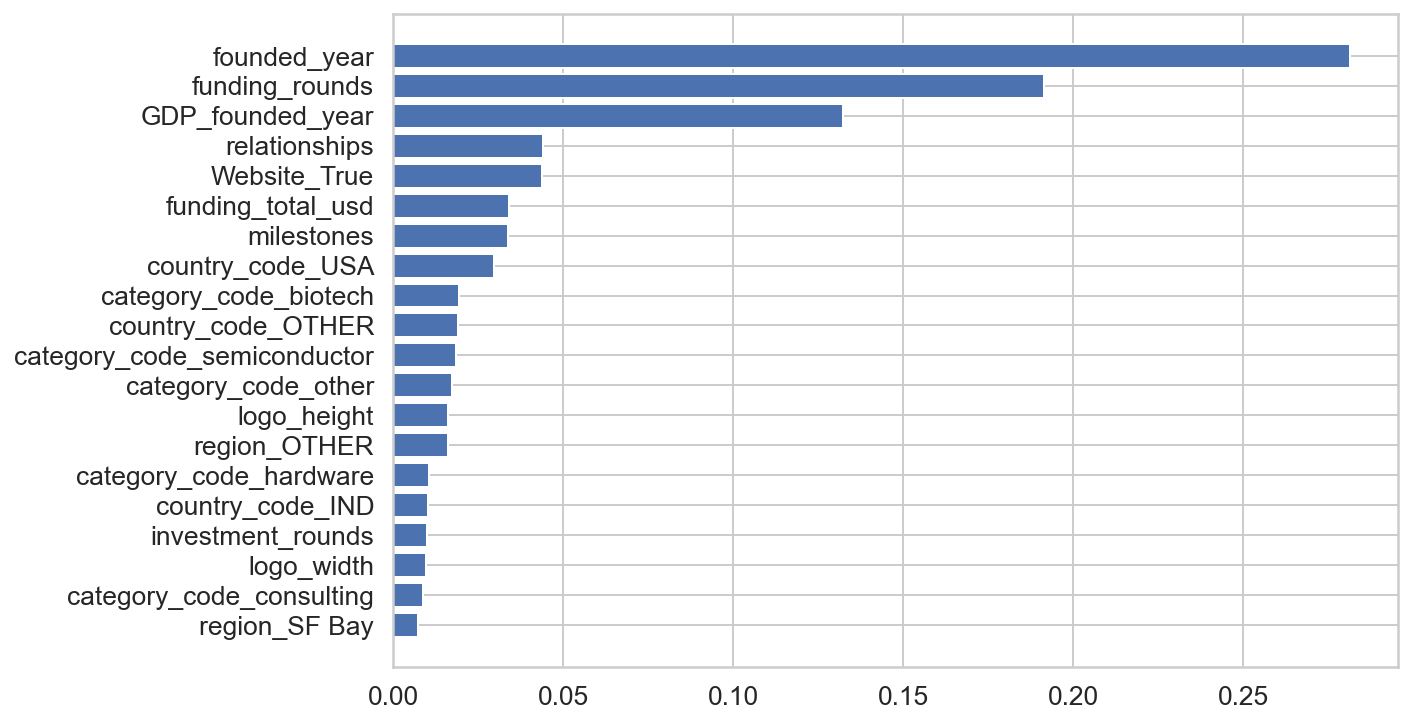

In [65]:
sorted_idx = gbm.feature_importances_.argsort()[-20:]
plt.barh(X_te.columns[sorted_idx], gbm.feature_importances_[sorted_idx])

# Visualize Model performance

In [ ]:
import wandb
wandb.init(project="visualize-sklearn")

In [ ]:
knn_model=KNeighborsClassifier(n_neighbors=10)
lr_model = LogisticRegression(C=0.95)
nb_model = GaussianNB()
svc_model= SVC(probability=True)
XGB_model= XGBClassifier()
dt_model = DecisionTreeClassifier(max_depth=3)
rf_model = RandomForestClassifier(n_estimators=500)
et_model = ExtraTreesClassifier()
ada_model = AdaBoostClassifier()

In [124]:
def plot_roc1(true, probas, model_names):

    for i in range(len(probas)):
        fpr, tpr, thresholds = roc_curve(true, probas[i][:,1])
        auc = roc_auc_score(true, probas[i][:,1])
        plt.plot(fpr, tpr, marker='o', label=f"{model_names[i][0]} : {round(auc, 2)}")

    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)')
    plt.title("ROC Curve");

In [132]:
#probas1 = [c.predict_proba(X_tr) for n,c in model_list]
probas2 = [c.predict_proba(X_v) for n,c in model_list]

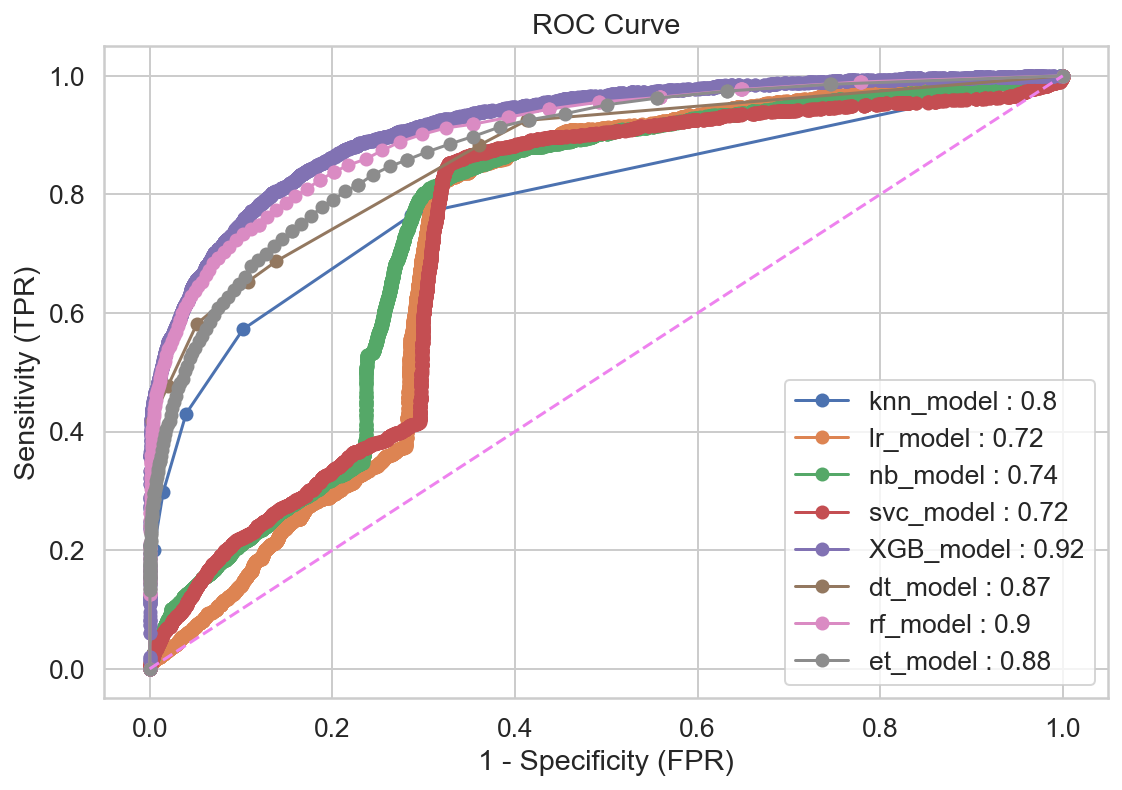

In [133]:
plot_roc1(y_v, probas2, model_list)
plt.legend()
plt.show();

## Decision Tree

accuracy score:  0.9166111850865513
training score: 0.9159929617652653
testing score: 0.9166111850865513
confusion_matrix: 
 [[15465    32]
 [ 1471  1056]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     15497
           1       0.97      0.42      0.58      2527

    accuracy                           0.92     18024
   macro avg       0.94      0.71      0.77     18024
weighted avg       0.92      0.92      0.90     18024



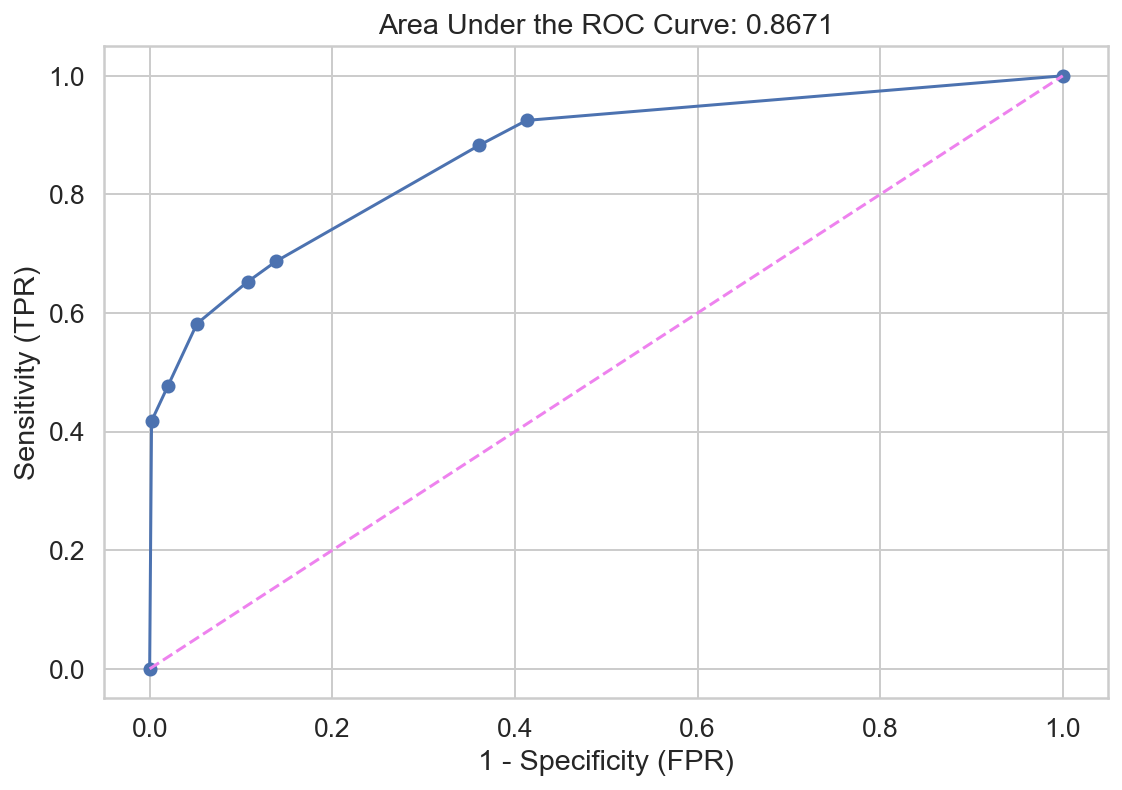

In [69]:
dt_model = DecisionTreeClassifier(max_depth=3)
dt_model.fit(X_tr, y_tr)

y_pred = dt_model.predict(X_v)
print("accuracy score: ",accuracy_score(y_v, y_pred))
print("training score: {}".format(dt_model.score(X_tr, y_tr)))
print("testing score: {}".format(dt_model.score(X_v, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, dt_model.predict(X_v)))
print(classification_report(y_v, y_pred))

proba=dt_model.predict_proba(X_v)[:,1]
fpr, tpr, thresholds = roc_curve(y_v, proba)
plot_roc(y_v, proba)

accuracy score:  0.920511284202117
testing score: 0.920511284202117
confusion_matrix: 
 [[12903    12]
 [ 1182   924]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     12915
           1       0.99      0.44      0.61      2106

    accuracy                           0.92     15021
   macro avg       0.95      0.72      0.78     15021
weighted avg       0.93      0.92      0.91     15021



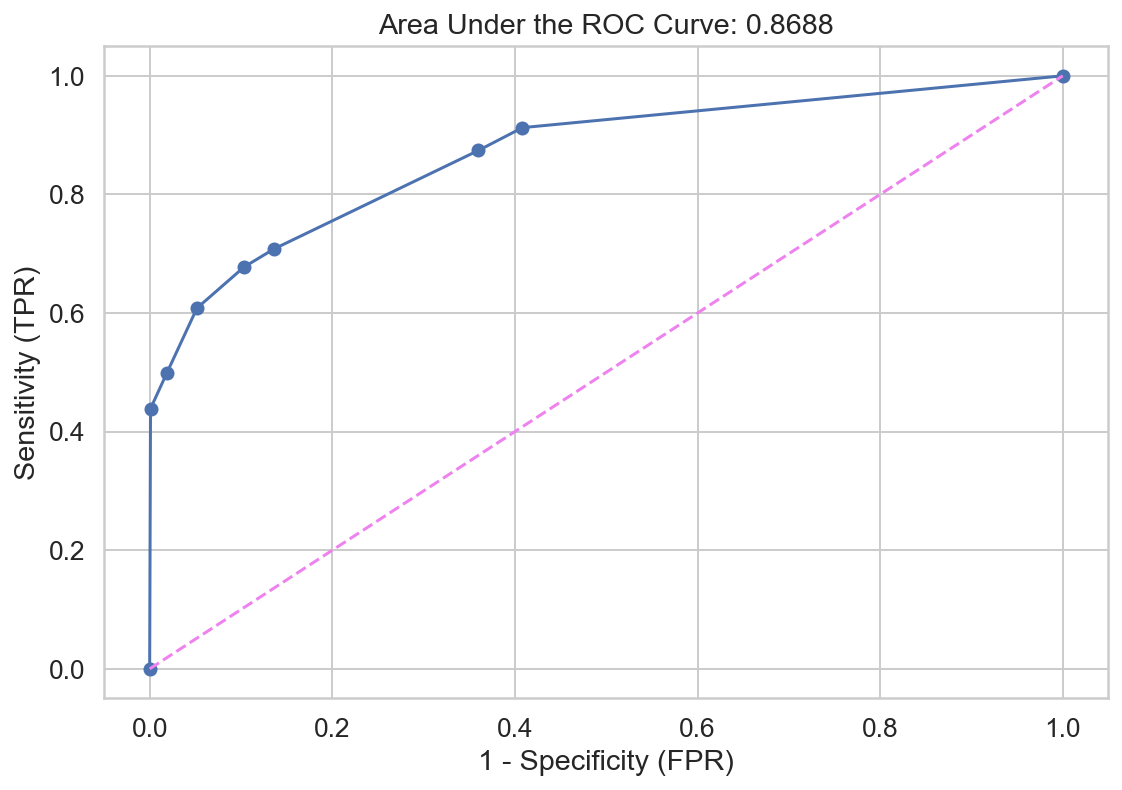

In [71]:
y_pred = dt_model.predict(X_te)
print("accuracy score: ",accuracy_score(y_te, y_pred))

print("testing score: {}".format(dt_model.score(X_te, y_te)))
print("confusion_matrix: \n", confusion_matrix(y_te, dt_model.predict(X_te)))
print(classification_report(y_te, y_pred))

proba=dt_model.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, proba)
plot_roc(y_te, proba)

# KNN Model

accuracy score:  0.8919773635153129
training score: 0.9012982689747004
testing score: 0.8919773635153129
confusion_matrix: 
 [[15105   392]
 [ 1555   972]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     15497
           1       0.71      0.38      0.50      2527

    accuracy                           0.89     18024
   macro avg       0.81      0.68      0.72     18024
weighted avg       0.88      0.89      0.88     18024



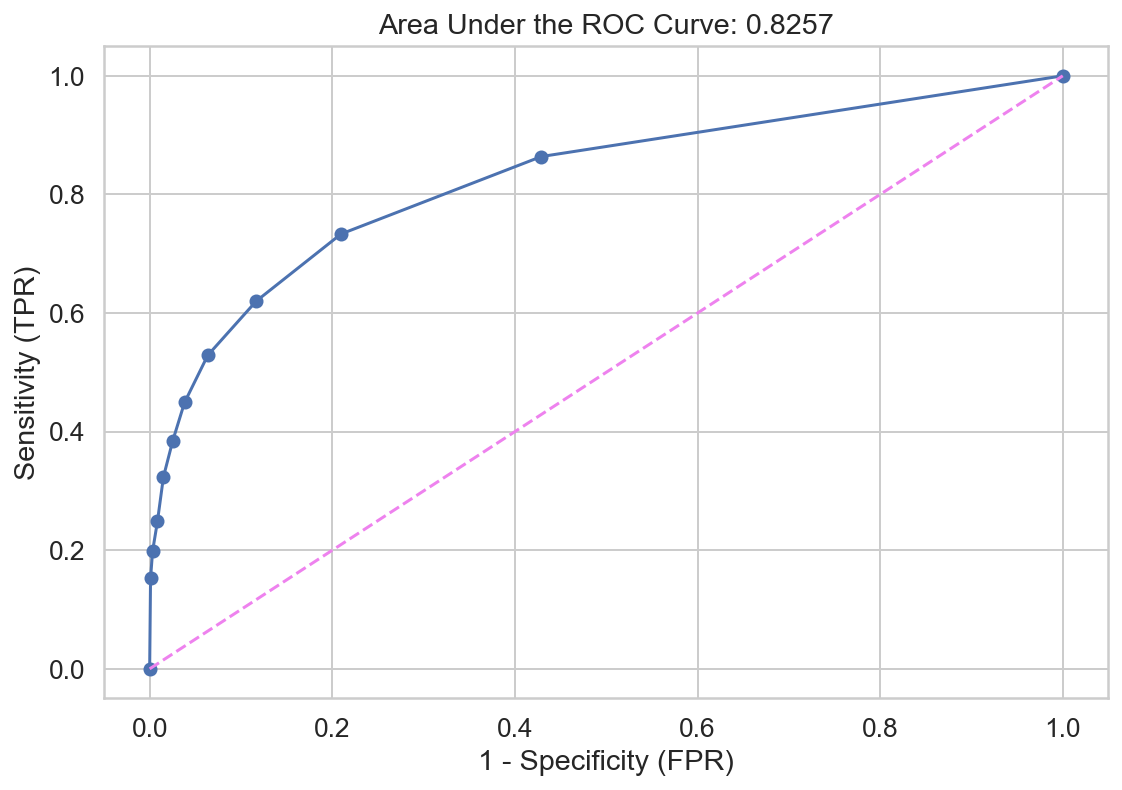

In [73]:
knn_model=KNeighborsClassifier(n_neighbors=10)
knn_model.fit(X_tr,y_tr)

y_pred = knn_model.predict(X_v)
print("accuracy score: ",accuracy_score(y_v, y_pred))
print("training score: {}".format(knn_model.score(X_tr, y_tr)))
print("testing score: {}".format(knn_model.score(X_v, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, knn_model.predict(X_v)))
print(classification_report(y_v, y_pred))

proba=knn_model.predict_proba(X_v)[:,1]
fpr, tpr, thresholds = roc_curve(y_v, proba)
plot_roc(y_v, proba)

# Random Forest

accuracy score:  0.9194407456724367
training score: 0.9997622217995055
testing score: 0.9194407456724367
confusion_matrix: 
 [[15339   158]
 [ 1294  1233]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     15497
           1       0.89      0.49      0.63      2527

    accuracy                           0.92     18024
   macro avg       0.90      0.74      0.79     18024
weighted avg       0.92      0.92      0.91     18024



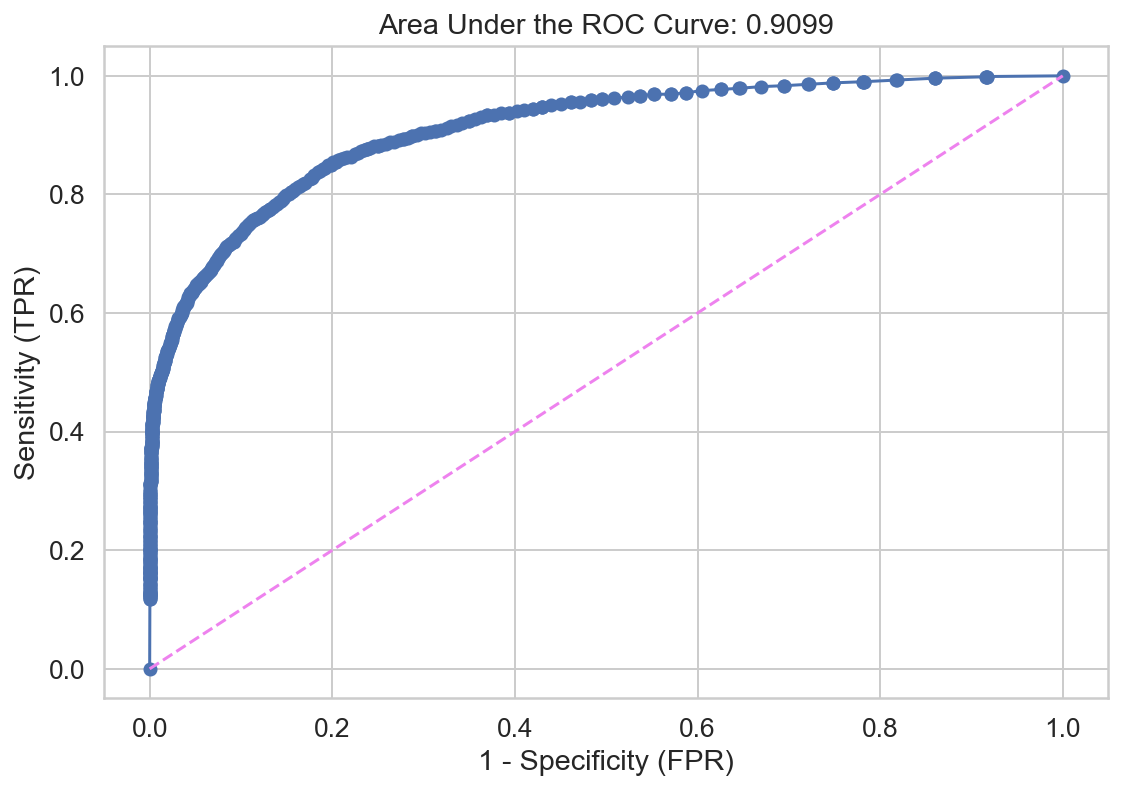

In [75]:
rf_model = RandomForestClassifier(n_estimators=500)
rf_model.fit(X_tr,y_tr)

y_pred = rf_model.predict(X_v)
print("accuracy score: ",accuracy_score(y_v, y_pred))
print("training score: {}".format(rf_model.score(X_tr, y_tr)))
print("testing score: {}".format(rf_model.score(X_v, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, rf_model.predict(X_v)))
print(classification_report(y_v, y_pred))

proba=rf_model.predict_proba(X_v)[:,1]
fpr, tpr, thresholds = roc_curve(y_v, proba)
plot_roc(y_v, proba)